In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import pickle
import torch
import torch.nn as nn
import time
import sympy as sy
import imageio
import glob 
import matplotlib.tri as tri

# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("../..")
parent_path = os.path.abspath(os.getcwd())

import sys 
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

# Import helper classes/functions
from network_helper import Net, MH_PINN_reg
from data_helper import pde_exact
from misc_helper import animation, training_results, knw_log, competitive_plot
from knw_helper import coeff, K_n_width

# Step 1: Load in and visualize data

In [2]:
PDE = 'allencahn'

with open(parent_path + '\\data\\' + 'allenCahn2D_dict.pickle', 'rb') as handle:
    allenCahn2D_dict = pickle.load(handle)

u_ls = np.array(allenCahn2D_dict['u'])
f_ls = np.array(allenCahn2D_dict['f'])
x = allenCahn2D_dict['x']
y = allenCahn2D_dict['y']

# Plot
X, Y = np.meshgrid(x,y)
XY = np.concatenate((X.flatten().reshape(-1,X.flatten().shape[-1]), Y.flatten().reshape(-1,Y.flatten().shape[-1]))).T
triang = tri.Triangulation(X.flatten(), Y.flatten())
xb = np.concatenate((np.concatenate((np.array([X[0,:],Y[0,:]]),np.array([X[-1,:],Y[-1,:]])),-1),np.concatenate((np.array([X[:,0],Y[:,0]]),np.array([X[:,-1],Y[:,-1]])),-1)),-1).T

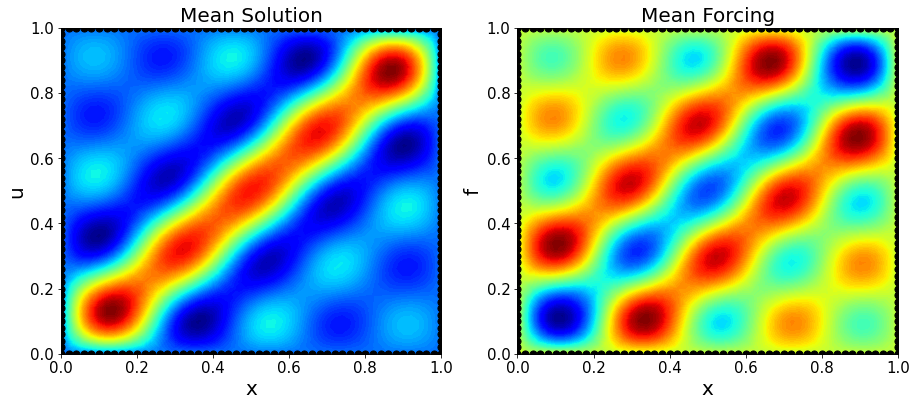

In [3]:
# Plot
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.tricontourf(triang, np.mean(np.array(u_ls),0).flatten(), 100, cmap = 'jet')
plt.subplot(1,2,2)
plt.tricontourf(triang, np.mean(np.array(f_ls),0).flatten(), 100, cmap = 'jet')
    
plt.subplot(1,2,1)
plt.scatter(xb[:,0],xb[:,1], c ='k', s = 50)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Mean Solution', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15); 
plt.subplot(1,2,2)
plt.scatter(xb[:,0],xb[:,1], c ='k', s = 50)
plt.ylabel('f', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Mean Forcing', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15);

# Step 2: Initialize and train multitask model

In [4]:
torch.manual_seed(0); np.random.seed(0)

# MH-PINN
model_name = 'hydra_tanh_reg'
number_of_cases = 20
body_layers = [2, 20, 20]; head_layers = [20, 1]; act = 'tanh';
verbose = 1; epoch = 1000
model_mhpinn = MH_PINN_reg(XY, f_ls, xb, body_layers, head_layers, verbose, epoch, number_of_cases, act, PDE, X, Y)

In [5]:
print('MH-PINN')
start_time = time.time()
# Adam training
print('Train Adam:')
model_mhpinn.train_adam()
# LBFGS training
print('Train L-BFGS:')
# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 5000; max_eval = None; tolerance_grad = -1; tolerance_change = -1; history_size = 50
model_mhpinn.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

MH-PINN
Train Adam:
epoch 0, total loss: 6640.2
epoch 0, Kwn loss: 1058.54
epoch 100, total loss: 5757.89
epoch 100, Kwn loss: 218.197
epoch 200, total loss: 5764.64
epoch 200, Kwn loss: 228.519
epoch 300, total loss: 5773.43
epoch 300, Kwn loss: 238.409
epoch 400, total loss: 5782.57
epoch 400, Kwn loss: 248.081
epoch 500, total loss: 5791.75
epoch 500, Kwn loss: 257.615
epoch 600, total loss: 5800.85
epoch 600, Kwn loss: 267.029
epoch 700, total loss: 5809.77
epoch 700, Kwn loss: 276.302
epoch 800, total loss: 5818.38
epoch 800, Kwn loss: 285.38
epoch 900, total loss: 5826.56
epoch 900, Kwn loss: 294.178
Knw: tensor(469.9034, dtype=torch.float64)
Train L-BFGS:
total loss:1716.3
Kwn loss: 152.685
total loss:1266.43
Kwn loss: 130.968
total loss:879.177
Kwn loss: 107.202
total loss:456.962
Kwn loss: 90.1995
total loss:205.87
Kwn loss: 86.446
total loss:156.245
Kwn loss: 77.594
total loss:131.768
Kwn loss: 72.0623
total loss:119.055
Kwn loss: 67.624
total loss:107.882
Kwn loss: 59.4155
t

# Step 3: Visualize training results

Relative L2 Error (mean): 0.2493994750579865
Relative L2 Error (std): 0.12065761302813574
Relative L2 Error (median): 0.2257977901991211
Relative L2 Error (min-max): [0.09870448778083593, 0.5354547369642559]
2-Norm Error (mean): 7.3111923318454615
2-Norm Error (std): 3.348899695073229


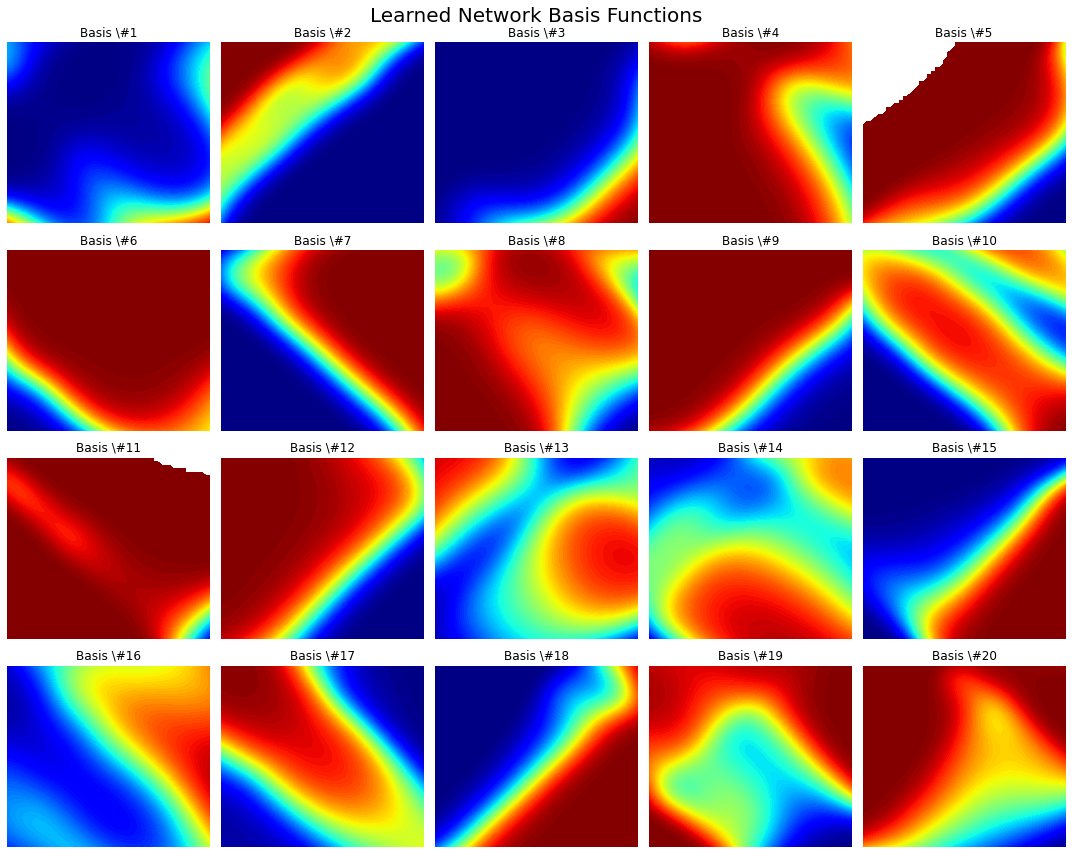

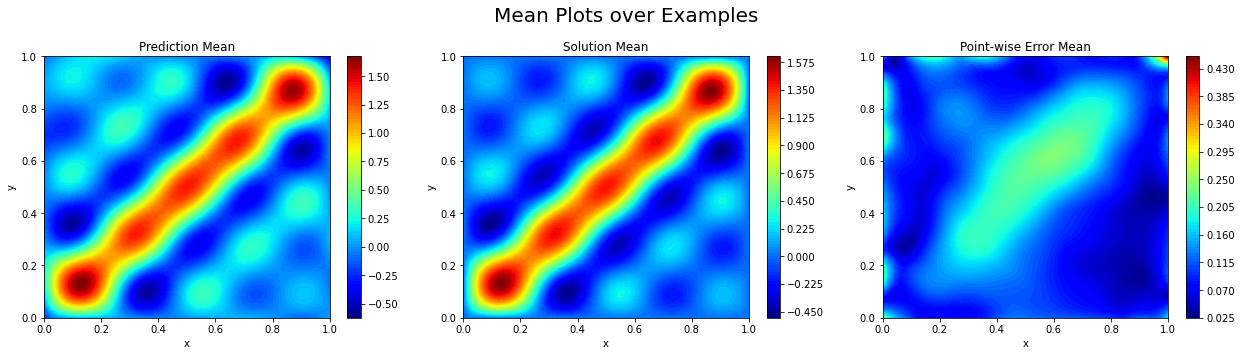

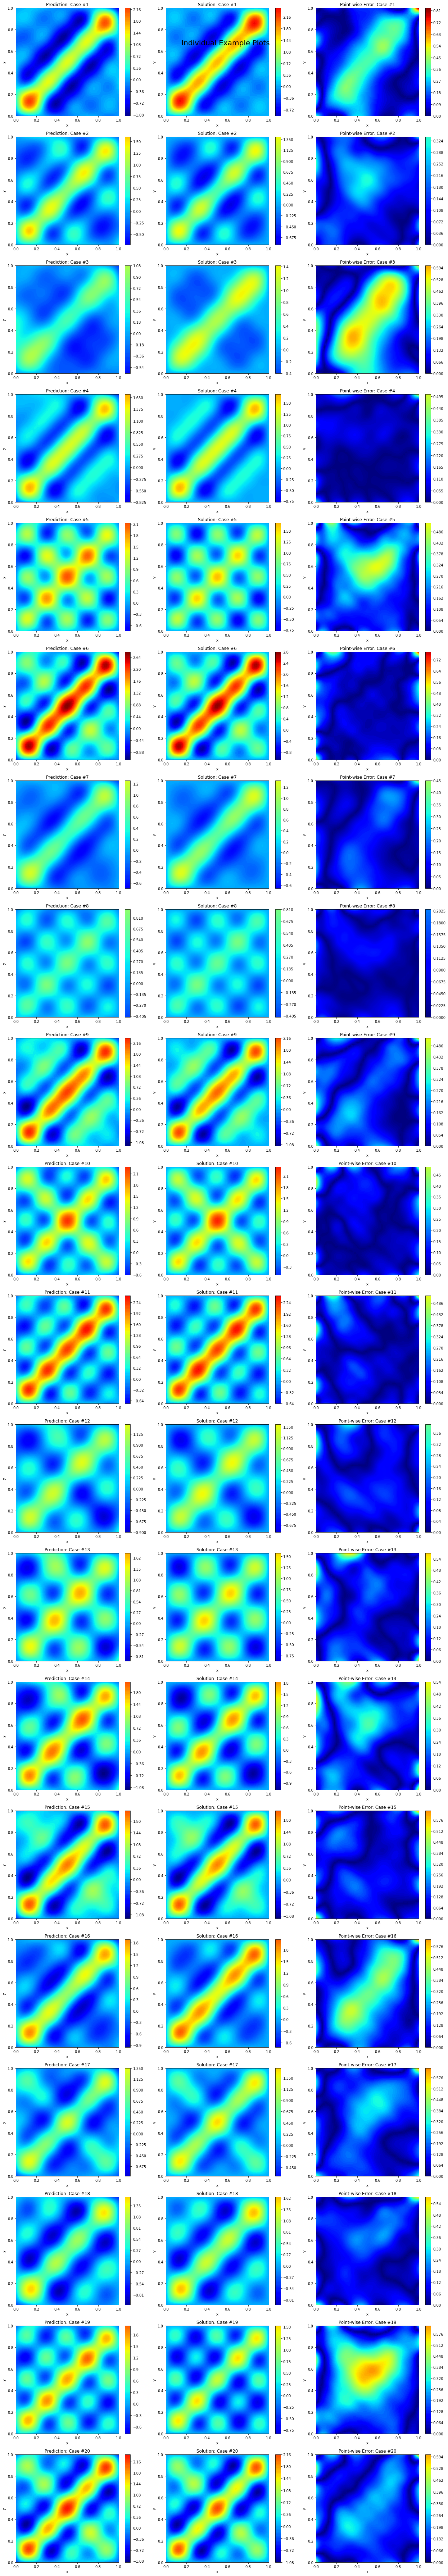

In [6]:
# Predictions
mhpinn_u_pred, basis = model_mhpinn.predict(XY)
# Call helper function
l2_error_ls = training_results(number_of_cases, x, xb, u_ls, mhpinn_u_pred, basis, body_layers, path, model_name, PDE, triang)

# Step 4: Compute K n-width metric

In [7]:
# Competative optimization
exact = pde_exact() # Needed for error estimate
solution_basis = np.array([(np.sin(X*np.pi)*np.sin(Y*np.pi)).flatten(), (np.sin(2*X*np.pi)*np.sin(2*Y*np.pi)).flatten(), (np.sin(3*X*np.pi)*np.sin(3*Y*np.pi)).flatten(), (np.sin(4*X*np.pi)*np.sin(4*Y*np.pi)).flatten(), (np.sin(5*X*np.pi)*np.sin(5*Y*np.pi)).flatten()])
model_basis = basis.numpy().T

In [8]:
# Create bi-optimization problem
torch.manual_seed(1); np.random.seed(1)
verbose = 0; adam_lr = 0.001; animate = 0; comp_plot = 1
KnW = K_n_width(solution_basis, model_basis, adam_lr, verbose, exact, 0, model_mhpinn.sol_coeff().detach(), model_mhpinn.pred_coeff().detach())

In [9]:
# Training and animation
epochs = 5000
gif_num = 100; subepoch = int(epochs/gif_num)
log = knw_log()

fig_num = 0
for i in range(gif_num):
    u_c_optimized, u_W1_optimized, u_c_coeff, u_W1_coeff = KnW.solution()
    log.add(x, u_c_optimized, u_W1_optimized)
    if animate == 1:
        animation(path, model_name, fig_num, x, u_c_optimized, u_W1_optimized, PDE, y, triang)
    KnW.train_adam(subepoch)
    fig_num += 1

knw_metric = KnW.metric().detach().numpy()
knw_l2_error = np.linalg.norm(u_c_optimized.detach().numpy()-u_W1_optimized.detach().numpy(), 2)/np.linalg.norm(u_c_optimized.detach().numpy(), 2)
print('KnW Metric:', knw_metric)
print('KnW Rel L2 Error:', knw_l2_error)

KnW Metric: 4.741931148454878
KnW Rel L2 Error: 0.09823058911658218


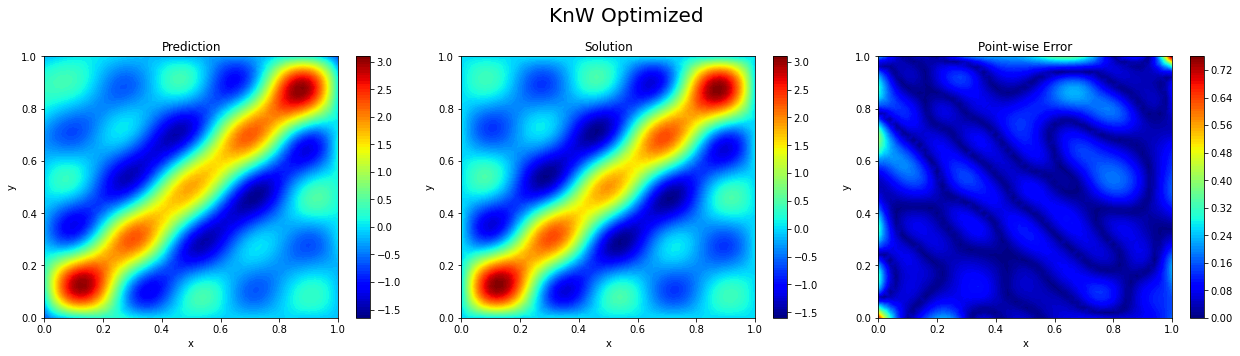

In [10]:
if animate == 1:
    impath = glob.glob(path + '\\figures\\' + model_name + '_animate_' + '*.png')
    images = [];
    for filename in impath:
        images.append(imageio.imread(filename))
    imageio.mimsave(path + '\\figures\\' + model_name + '.mp4', images, macro_block_size = 1)
    
if comp_plot == 1:
    competitive_plot(path, model_name, log.report(), len(log.report())-1, PDE, x, y, triang)

In [11]:
# Save data
log_dict = {'l2_error_ls': l2_error_ls, 'knw_l2_error': knw_l2_error, 'model_basis': model_basis, 'knw_log': log.report()}

with open(path + '\\log\\' + model_name + '_log_dict.pickle', 'wb') as handle:
    pickle.dump(log_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)